In [2]:
pip install mne-icalabel

Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import mne
from mne_icalabel import label_components
from scipy.stats import pearsonr

In [4]:
raw_eeg_data = pd.read_parquet("/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/722738444.parquet")

sfreq = 200

raw_eeg_electrode_data = raw_eeg_data.iloc[:,:-1].to_numpy().T  
raw_eeg_channel_names = list(raw_eeg_data.iloc[:,:-1].columns)
channel_types = ["eeg"] * len(raw_eeg_channel_names)
ekg_data = raw_eeg_data.iloc[:, -1] 

info = mne.create_info(ch_names=raw_eeg_channel_names, sfreq=sfreq, ch_types=channel_types)
raw = mne.io.RawArray(raw_eeg_electrode_data, info)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.set_eeg_reference(ref_channels='average', ch_type = 'eeg')

raw.plot(scalings='auto', duration = 10, show_scrollbars=False);

Creating RawArray with float64 data, n_channels=19, n_times=14800
    Range : 0 ... 14799 =      0.000 ...    73.995 secs
Ready.
Applying average reference.
Applying a custom ('EEG',) reference.
Using matplotlib as 2D backend.


In [5]:
def plot_psd(raw, method='welch', fmin=0, fmax=100, tmin=0, tmax=np.inf, average=True, amplitude=False, picks='data', exclude='bads'):
    psd = raw.compute_psd(method=method, fmin=fmin, fmax=fmax, tmin=tmin, tmax=tmax, n_overlap = 100)
    psd.plot(average=average, amplitude=amplitude, picks=picks, exclude=exclude)

Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).


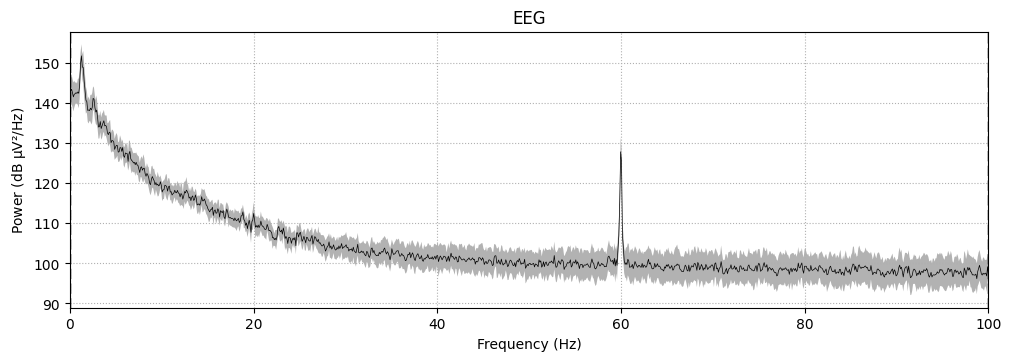

In [6]:
# raw.compute_psd().plot()
plot_psd(raw.copy(), method='welch', fmin=0, fmax=100, tmin=0, tmax=np.inf);

$\large\textit{1. Utilizing a notch filter to remove 60 Hz power line noise.}$ 

$\large\textit{2. Signal is filtered between \(1 - 50\) Hz using Butterworth band-pass filter to keep data up to high beta band. }$

$\large\textit{3. Baseline Correction. }$

$\large\textit{4. Independent Components Analysis. (ICA Decomposition, Artifact Identification \& Removal) }$

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 60.90 Hz)
- Filter length: 1321 samples (6.605 s)

Effective window size : 10.240 (s)
Plotting power spectral density (dB=True).
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 1.00, 50.00 Hz: -6.02, -6.02 dB

Effective window size : 10.240 (s)
Plotting p

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


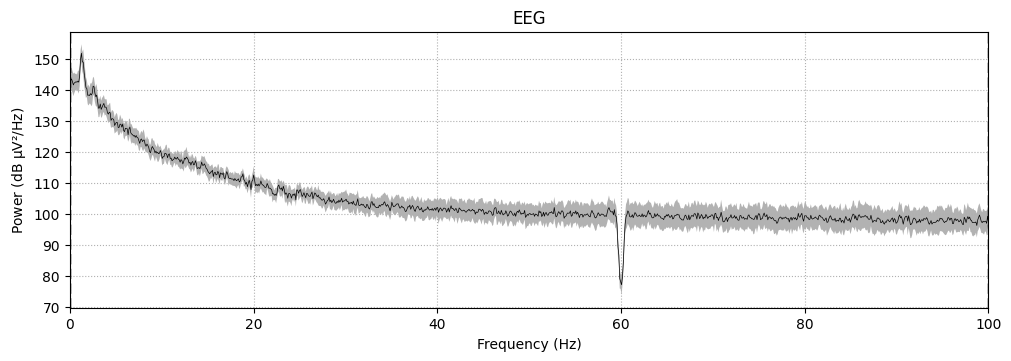

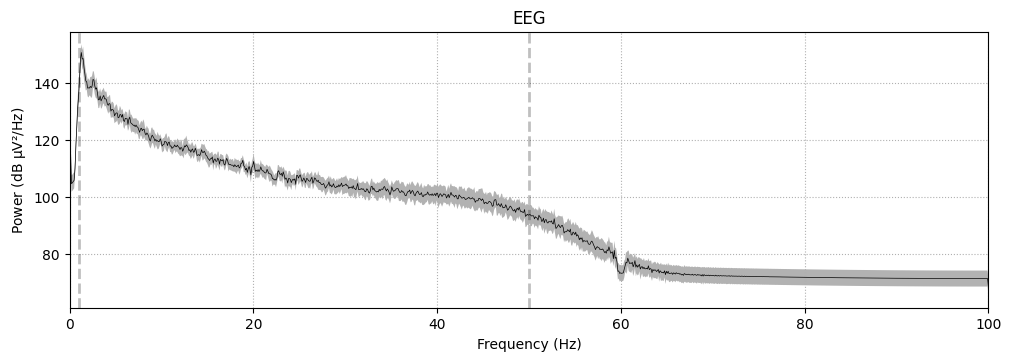

In [7]:
raw_unprocessed_data = raw.copy()

''' (i) Notch filter to remove the power line interference noise at 60 Hz in the American power grid '''

raw_unprocessed_data.notch_filter(60)
plot_psd(raw_unprocessed_data, method='welch', fmin=0, fmax=100, tmin=0, tmax=np.inf)
# raw_unprocessed_data.compute_psd().plot();

''' (ii) Butterworth Bans pass filter to keep data between (1 - 40 Hz) to remove Alising and High frequency effects'''

low_cut = 1
hi_cut  = 50
raw_unprocessed_data.filter(low_cut, hi_cut, method = 'iir', iir_params = None)
plot_psd(raw_unprocessed_data, method='welch', fmin=0, fmax=100, tmin=0, tmax=np.inf)
# raw_unprocessed_data.compute_psd().plot();


''' (iii) Baseline Correction to center the data at mean'''

extract_data = raw_unprocessed_data.get_data() 
times = raw_unprocessed_data.times
baseline_corrected_eeg = mne.baseline.rescale(extract_data, times, baseline = (None, None), mode = 'mean')
info = raw_unprocessed_data.info 
baseline_corrected_eeg = mne.io.RawArray(baseline_corrected_eeg, info)

# baseline_corrected_eeg.plot(scalings='auto', duration = 10, show_scrollbars=False);

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 18 components
Computing Extended Infomax ICA
Fitting ICA took 5.5s.
Ready.


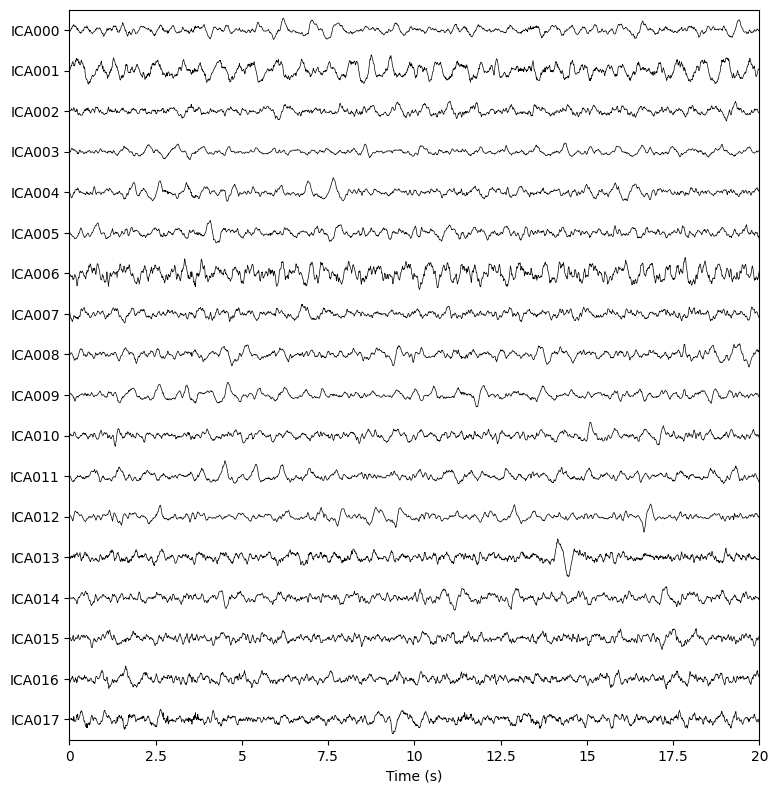

<ipython-input-8-a4423d926f3f>:20: RuntimeWarning: The provided Raw instance is not filtered between 1 and 100 Hz. ICLabel was designed to classify features extracted from an EEG dataset bandpass filtered between 1 and 100 Hz (see the 'filter()' method for Raw and Epochs instances).
  labels = label_components(baseline_corrected_eeg.copy(), ica, method='iclabel')


{'y_pred_proba': array([0.7396442 , 0.8255434 , 0.95464027, 0.7861854 , 0.50165576,
       0.9428005 , 0.9862294 , 0.59839785, 0.5132448 , 0.5361365 ,
       0.88443506, 0.8020078 , 0.49879715, 0.81174785, 0.6030762 ,
       0.96402276, 0.735424  , 0.9126638 ], dtype=float32), 'labels': ['brain', 'brain', 'brain', 'other', 'brain', 'brain', 'brain', 'other', 'brain', 'other', 'brain', 'brain', 'other', 'brain', 'brain', 'brain', 'brain', 'other']}
Applying ICA to Raw instance
    Transforming to ICA space (18 components)
    Zeroing out 5 ICA components
    Projecting back using 19 PCA components


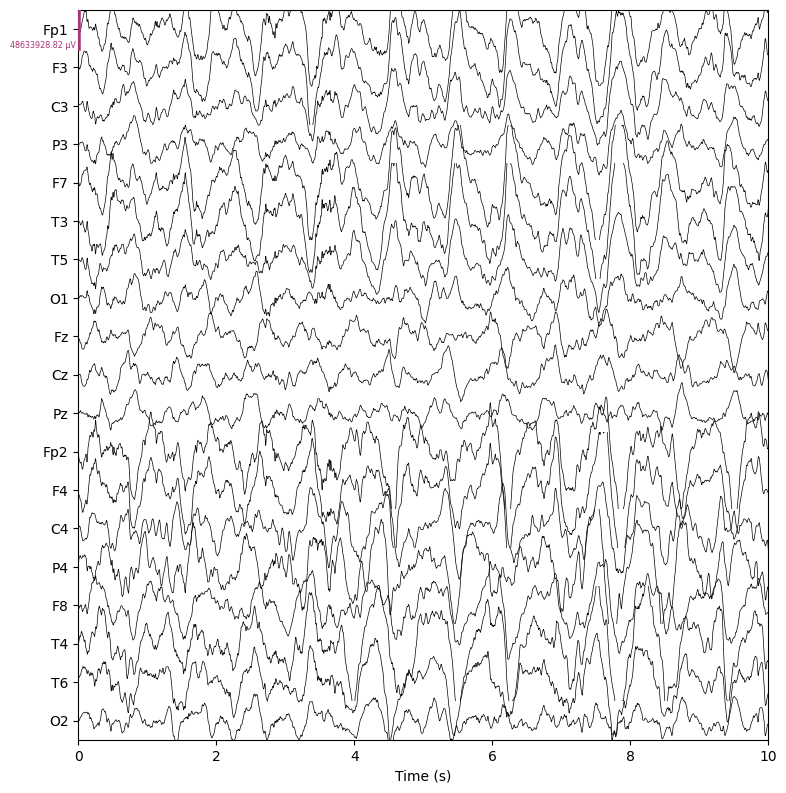

In [8]:
''' (iv) Independent Components Analysis. (ICA Decomposition, Artifact Identification & Removal'''

ica = mne.preprocessing.ICA(n_components = 18, noise_cov = None, random_state = 0, method = 'infomax', fit_params=dict(extended=True), max_iter = 'auto')
ica.fit(baseline_corrected_eeg.copy())

mne.viz.plot_ica_components(ica, ch_type = 'eeg', inst = 'raw', plot_std = True, sensors = True, show_names = True, contours = 6, image_interp='cubic', 
                           extrapolate='auto', border='mean', res=64, size=1, cmap='RdBu_r', vlim=(None, None), cnorm=None, colorbar=False, cbar_fmt='%3.2f', 
                           axes=None, title=None, nrows='auto', ncols='auto', show=True, image_args=None, psd_args=None, verbose=None )
ica.plot_sources(baseline_corrected_eeg.copy(), show_scrollbars=False)

ica_sources = ica.get_sources(baseline_corrected_eeg).get_data()

CORR_THRESHOLD = 0.9  
ekg_indices = []
for i in range(ica_sources.shape[0]): 
    corr, _ = pearsonr(ica_sources[i, :], ekg_data)
    if abs(corr) > CORR_THRESHOLD:
        ekg_indices.append(i)

labels = label_components(baseline_corrected_eeg.copy(), ica, method='iclabel')
print(labels)
non_brain_labels = ['muscle artifact', 'eye blink', 'heart beat', 'line noise', 'channel noise', 'other']
non_brain_indices = [idx for idx, label in enumerate(labels["labels"]) if label in non_brain_labels]

total_exclude = list(set(non_brain_indices + ekg_indices))

ica.exclude = total_exclude
processed_data = ica.apply(baseline_corrected_eeg.copy())

processed_data.plot(scalings='auto', duration = 10, show_scrollbars=False, remove_dc = True);

In [24]:
processed_data

<RawArray | 19 x 14800 (74.0 s), ~2.2 MiB, data loaded>

In [9]:
def plot_eeg_signals(bipolar_montage, label, time_limit=4000, offset=200):
    
    channel_groups = {
        'LL': [('Fp1','F7'), ('F7','T3'), ('T3','T5'), ('T5','O1')],  # Left Lateral (Blue)
        'LP': [('Fp2','F8'), ('F8', 'T4'), ('T4', 'T6'), ('T6','O2')],  # Left Parietal (Green)
        'RL': [('Fp2','F4'), ('F4','C4'), ('C4','P4'), ('P4','O2')],  # Right Lateral (Red)
        'RP': [('Fp1','F3'), ('F3','C3'), ('C3','P3'), ('P3','O1')],  # Right Parietal (Orange)
        'Central': [('Fz','Cz'), ('Cz','Pz')]  # Midline (Black)
    }
    color_mapping = {
        **{pair: 'blue' for pair in channel_groups['LL']},
        **{pair: 'green' for pair in channel_groups['LP']},
        **{pair: 'red' for pair in channel_groups['RL']},
        **{pair: 'orange' for pair in channel_groups['RP']},
        **{pair: 'black' for pair in channel_groups['Central']}
    }

    bipolar_montage_centered = bipolar_montage - bipolar_montage.mean(axis=0)

    plt.figure(figsize=(20, 10))
    ordered_channels = (
        [f"{col1} - {col2}" for col1, col2 in channel_groups['LL']] +
        [f"{col1} - {col2}" for col1, col2 in channel_groups['LP']] +
        [f"{col1} - {col2}" for col1, col2 in channel_groups['Central']] +
        [f"{col1} - {col2}" for col1, col2 in channel_groups['RP']] +
        [f"{col1} - {col2}" for col1, col2 in channel_groups['RL']]
    )[::-1]

    for i, channel in enumerate(ordered_channels):
        signal = bipolar_montage_centered[channel].values[:time_limit]
        assigned_color = color_mapping.get(tuple(channel.split(' - ')), 'black')
        plt.plot(signal + i * offset, color=assigned_color, label=channel if i == 0 else None)

    plt.title("EEG Signals", fontsize=20)
    plt.xlabel("Time (samples)", fontsize=14)
    plt.yticks(np.arange(0, len(ordered_channels) * offset, offset), ordered_channels)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.savefig(f"{label}.png")
    plt.tight_layout(pad=2.0)
    plt.show()

In [10]:
def create_bipolar_montage(eeg):

    bipolar_montage_pairs = [('Fp1','F7'), ('F7','T3'), ('T3','T5'), ('T5','O1'), 
                             ('Fp2','F8'), ('F8', 'T4'), ('T4', 'T6'), ('T6','O2'), 
                             ('Fp1','F3'), ('F3','C3'), ('C3','P3'), ('P3','O1'), 
                             ('Fp2','F4'), ('F4','C4'), ('C4','P4'),('P4','O2'),
                             ('Fz','Cz'), ('Cz','Pz')]
   
    data = eeg.get_data() 
    channel_names = eeg.ch_names

    bipolar_montage = pd.DataFrame()

    channel_indices = {name: i for i, name in enumerate(channel_names)}

    for col1, col2 in bipolar_montage_pairs:
        if col1 in channel_indices and col2 in channel_indices:  
            column_name = f"{col1} - {col2}"  
            bipolar_montage[column_name] = data[channel_indices[col1]] - data[channel_indices[col2]]

    return bipolar_montage

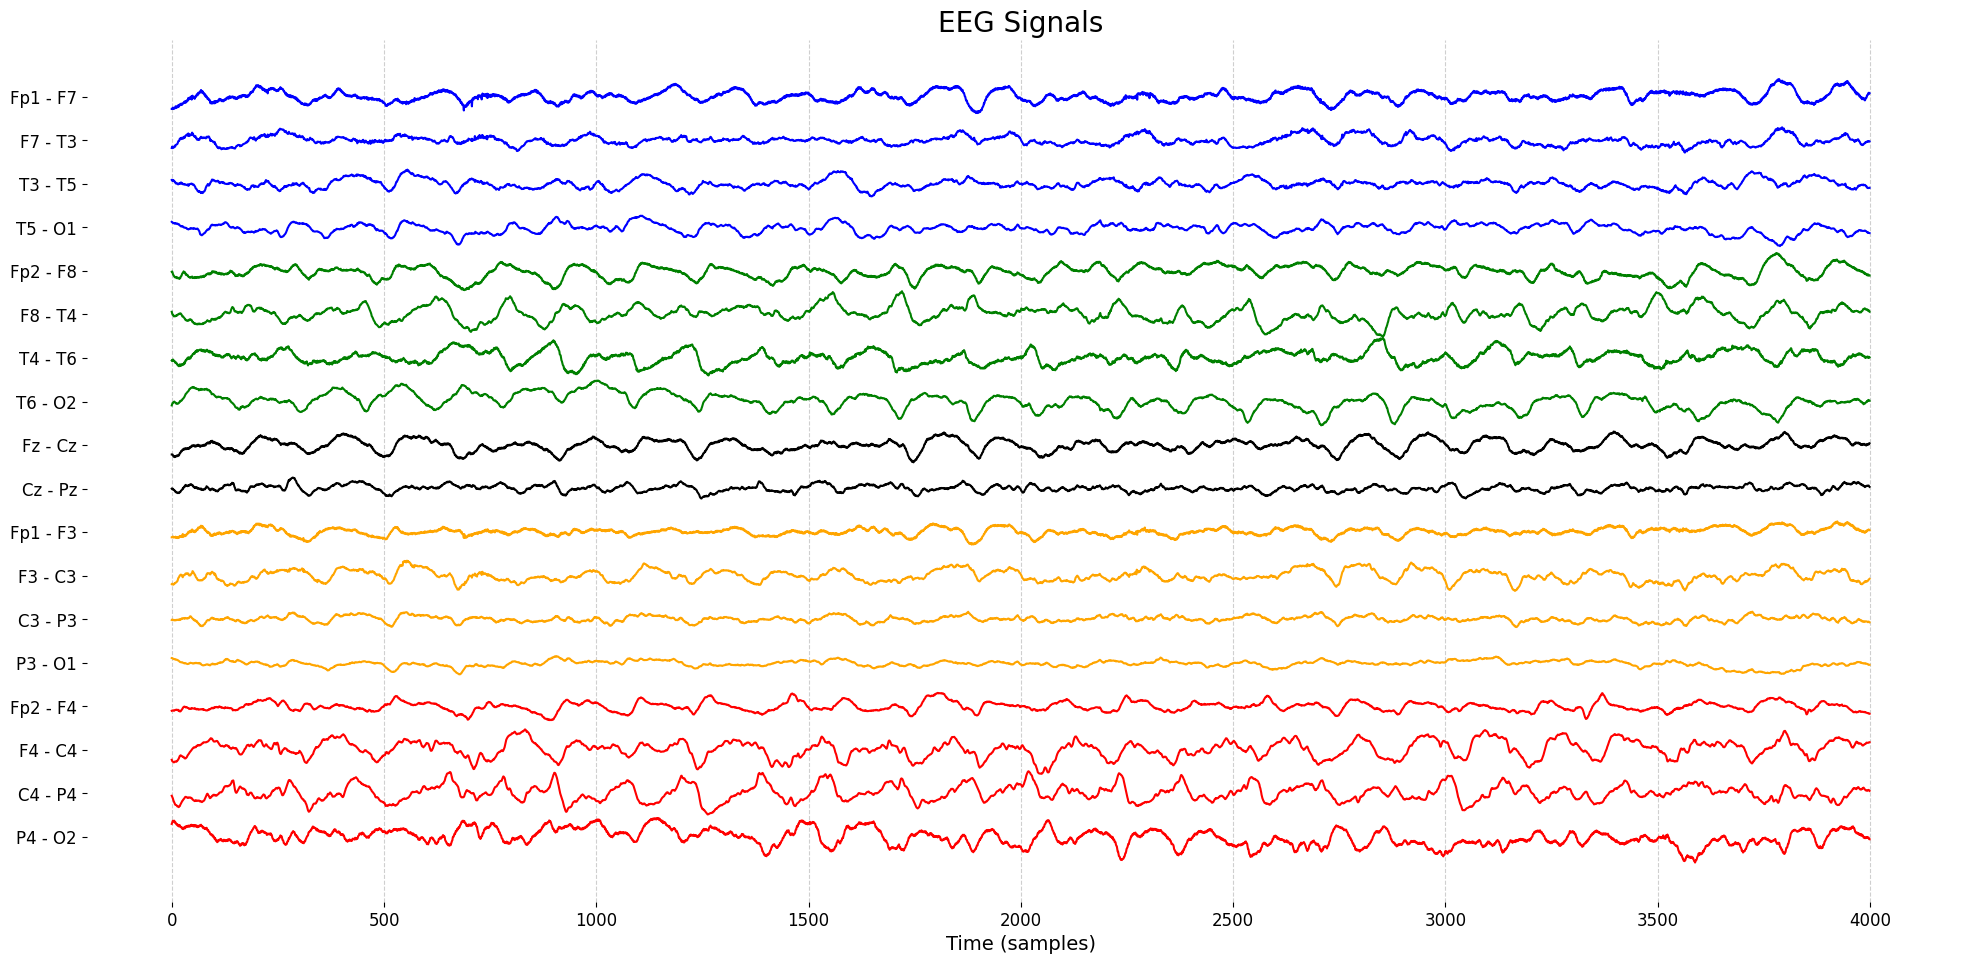

In [11]:
eeg_unprocessed = create_bipolar_montage(raw)
plot_eeg_signals(eeg_unprocessed, label = "unprocessed_eeg") 

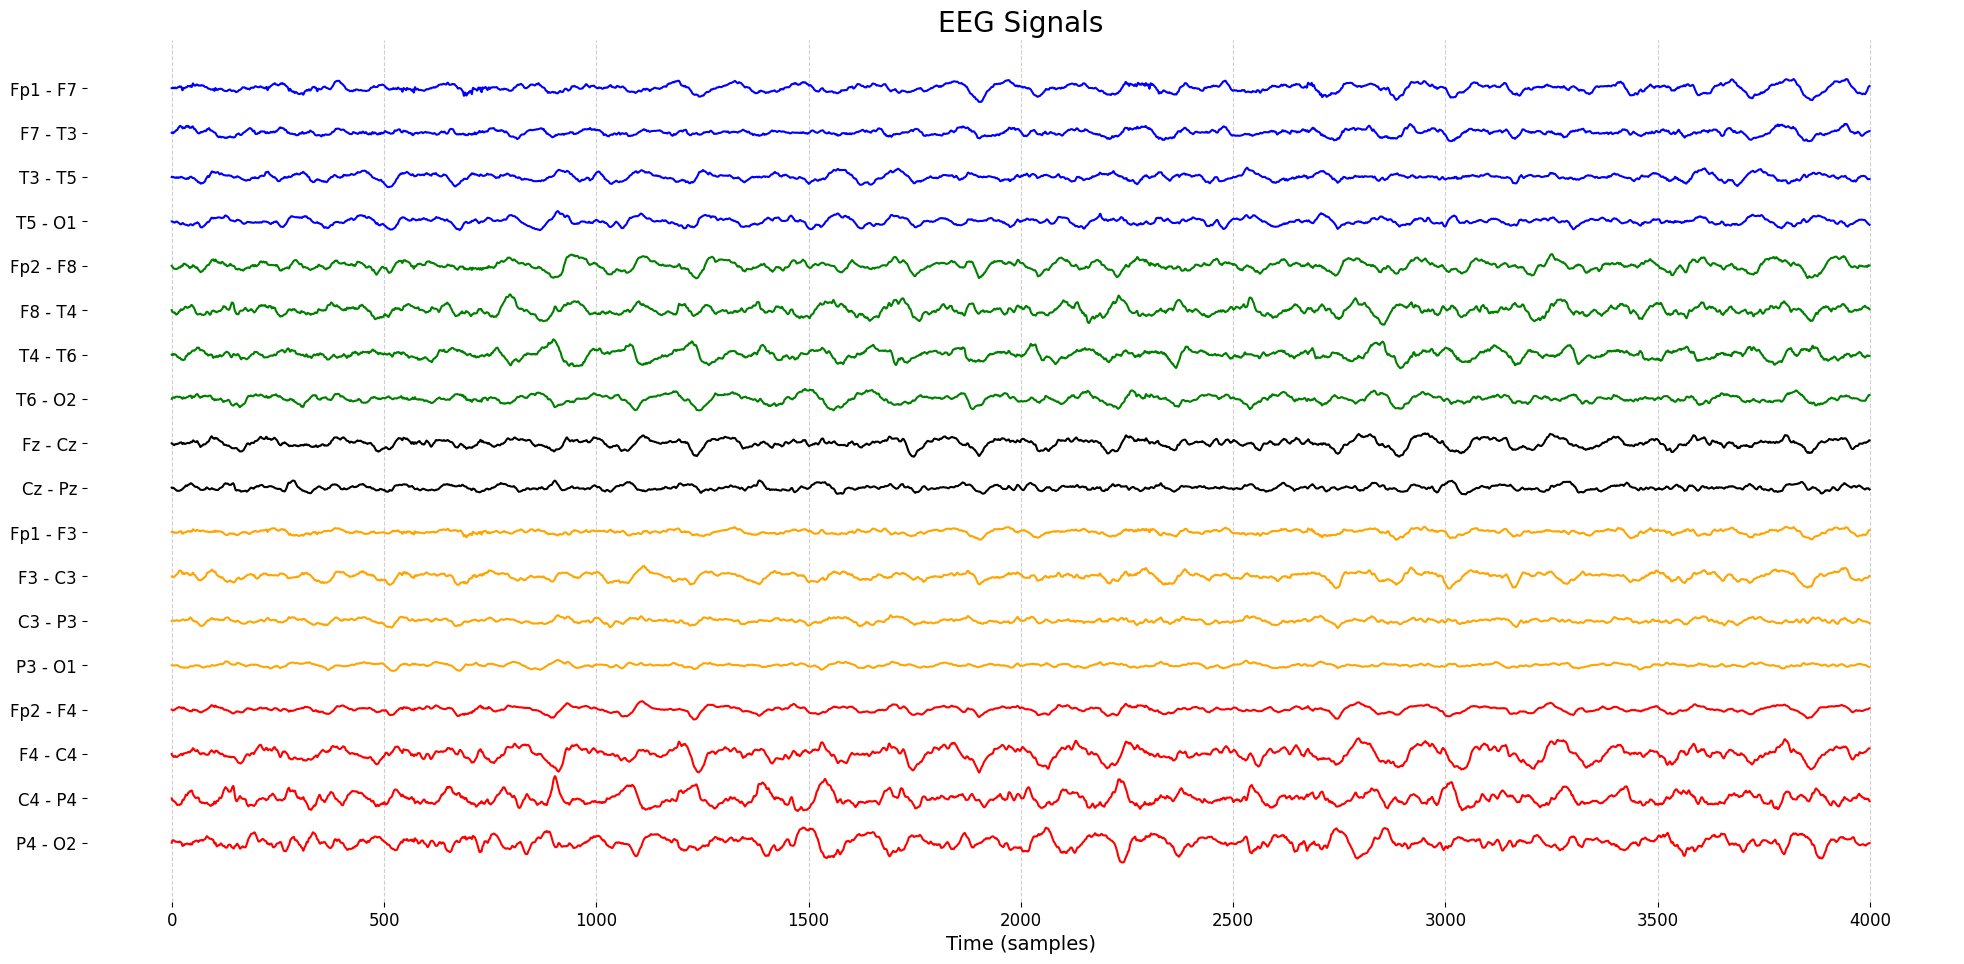

In [12]:
eeg_processed = create_bipolar_montage(processed_data)
plot_eeg_signals(eeg_processed, label = "processed_eeg")

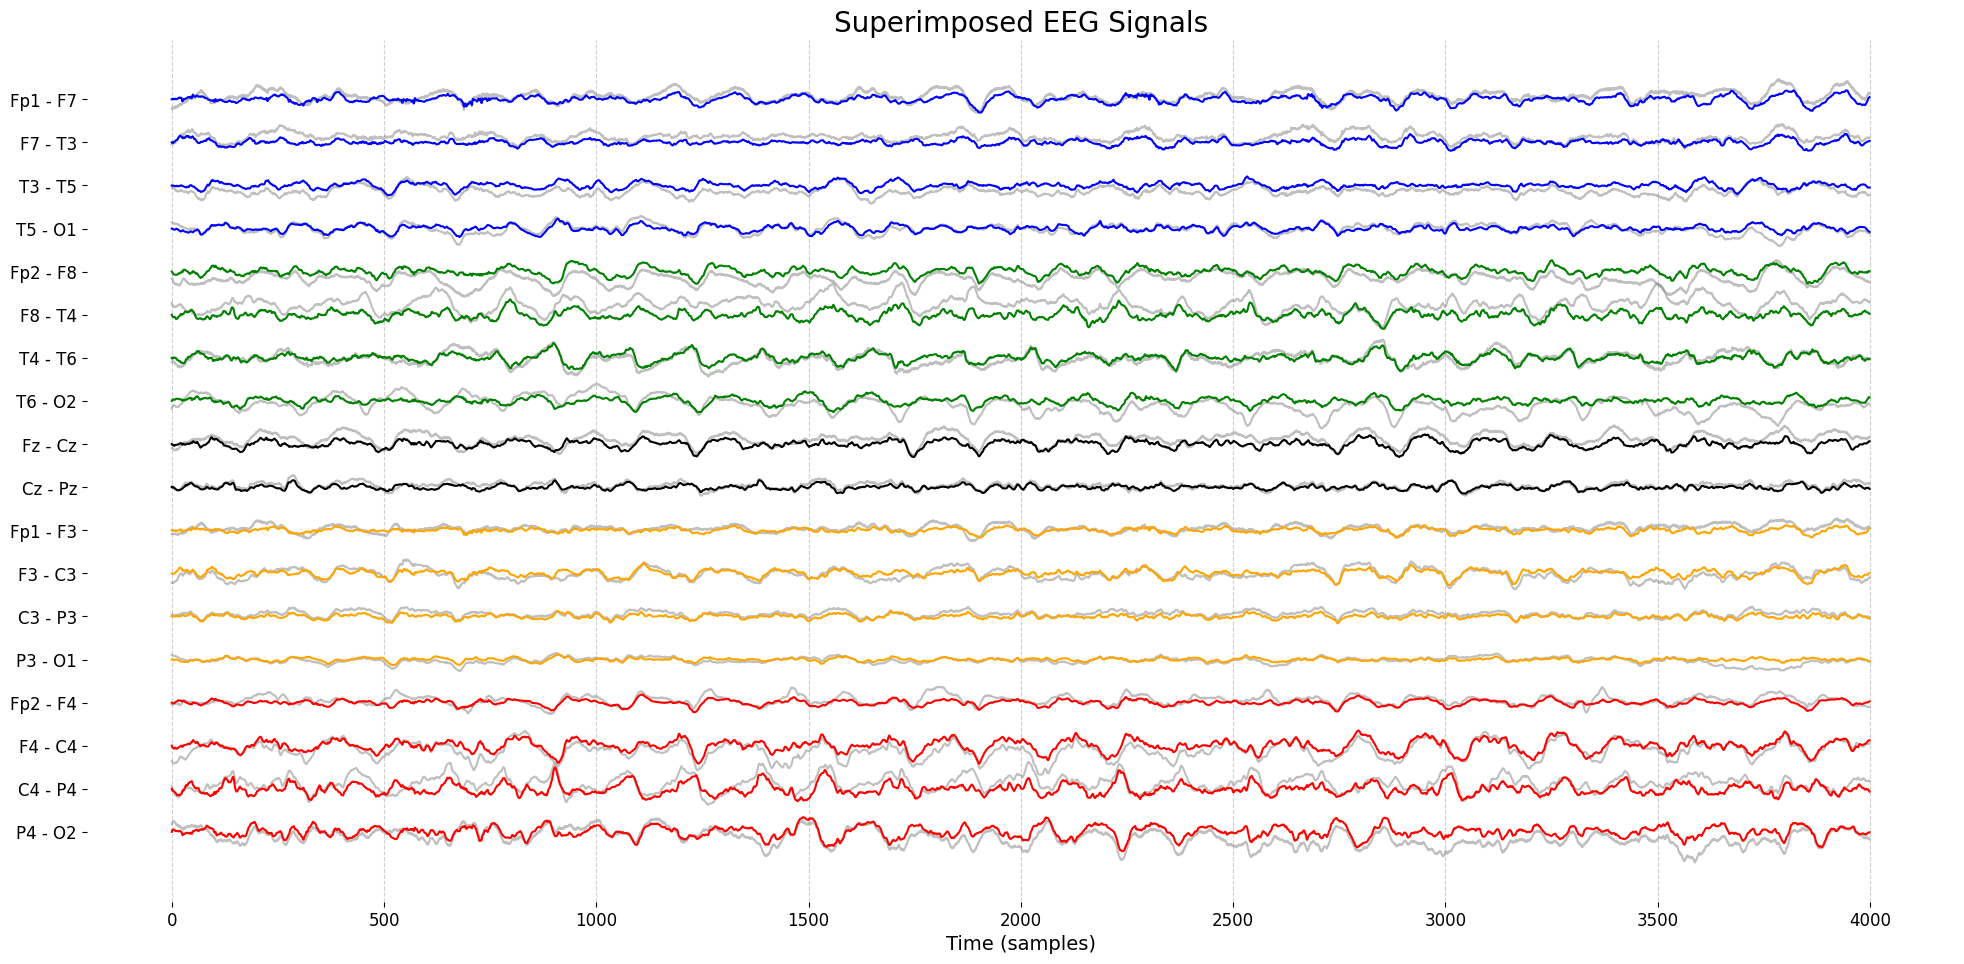

In [13]:
def plot_overlapped_eeg_signals(old_eeg_data, new_eeg_data, label, time_limit=4000, offset=200):
   
    # old_eeg_centered = old_eeg_data - np.mean(old_eeg_data, axis=0)
    # new_eeg_centered = new_eeg_data - np.mean(new_eeg_data, axis=0)

    channels = old_eeg_data.columns[::-1]

    plt.figure(figsize=(20, 10))

    channel_groups = {
        'LL': [('Fp1','F7'), ('F7','T3'), ('T3','T5'), ('T5','O1')],  
        'LP': [('Fp2','F8'), ('F8', 'T4'), ('T4', 'T6'), ('T6','O2')],  
        'RL': [('Fp2','F4'), ('F4','C4'), ('C4','P4'), ('P4','O2')], 
        'RP': [('Fp1','F3'), ('F3','C3'), ('C3','P3'), ('P3','O1')],  
        'Central': [('Fz','Cz'), ('Cz','Pz')] 
    }
    
    ordered_channels = (
        [f"{col1} - {col2}" for col1, col2 in channel_groups['LL']] +
        [f"{col1} - {col2}" for col1, col2 in channel_groups['LP']] +
        [f"{col1} - {col2}" for col1, col2 in channel_groups['Central']] +
        [f"{col1} - {col2}" for col1, col2 in channel_groups['RP']] +
        [f"{col1} - {col2}" for col1, col2 in channel_groups['RL']]
    )[::-1] 

    for i, channel in enumerate(ordered_channels):
        signal_old = old_eeg_data[channel].values[:time_limit]
        plt.plot(signal_old + i * offset, color='gray', alpha=0.5)  

    color_mapping = {
        **{pair: 'blue' for pair in channel_groups['LL']},
        **{pair: 'green' for pair in channel_groups['LP']},
        **{pair: 'red' for pair in channel_groups['RL']},
        **{pair: 'orange' for pair in channel_groups['RP']},
        **{pair: 'black' for pair in channel_groups['Central']}
    }

    for i, channel in enumerate(ordered_channels):
        signal_new = new_eeg_data[channel].values[:time_limit]
        assigned_color = color_mapping.get(tuple(channel.split(' - ')), 'black')
        plt.plot(signal_new + i * offset, color=assigned_color, linewidth=1.5) 

    plt.title("Superimposed EEG Signals", fontsize=20)
    plt.xlabel("Time (samples)", fontsize=14)
    plt.yticks(np.arange(0, len(ordered_channels) * offset, offset), ordered_channels)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='x', linestyle='--', alpha=0.6)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.savefig(f"{label}.png")
    plt.tight_layout(pad=2.0)
    plt.show()


plot_overlapped_eeg_signals(eeg_unprocessed, eeg_processed, label = "unprocessed_processed")

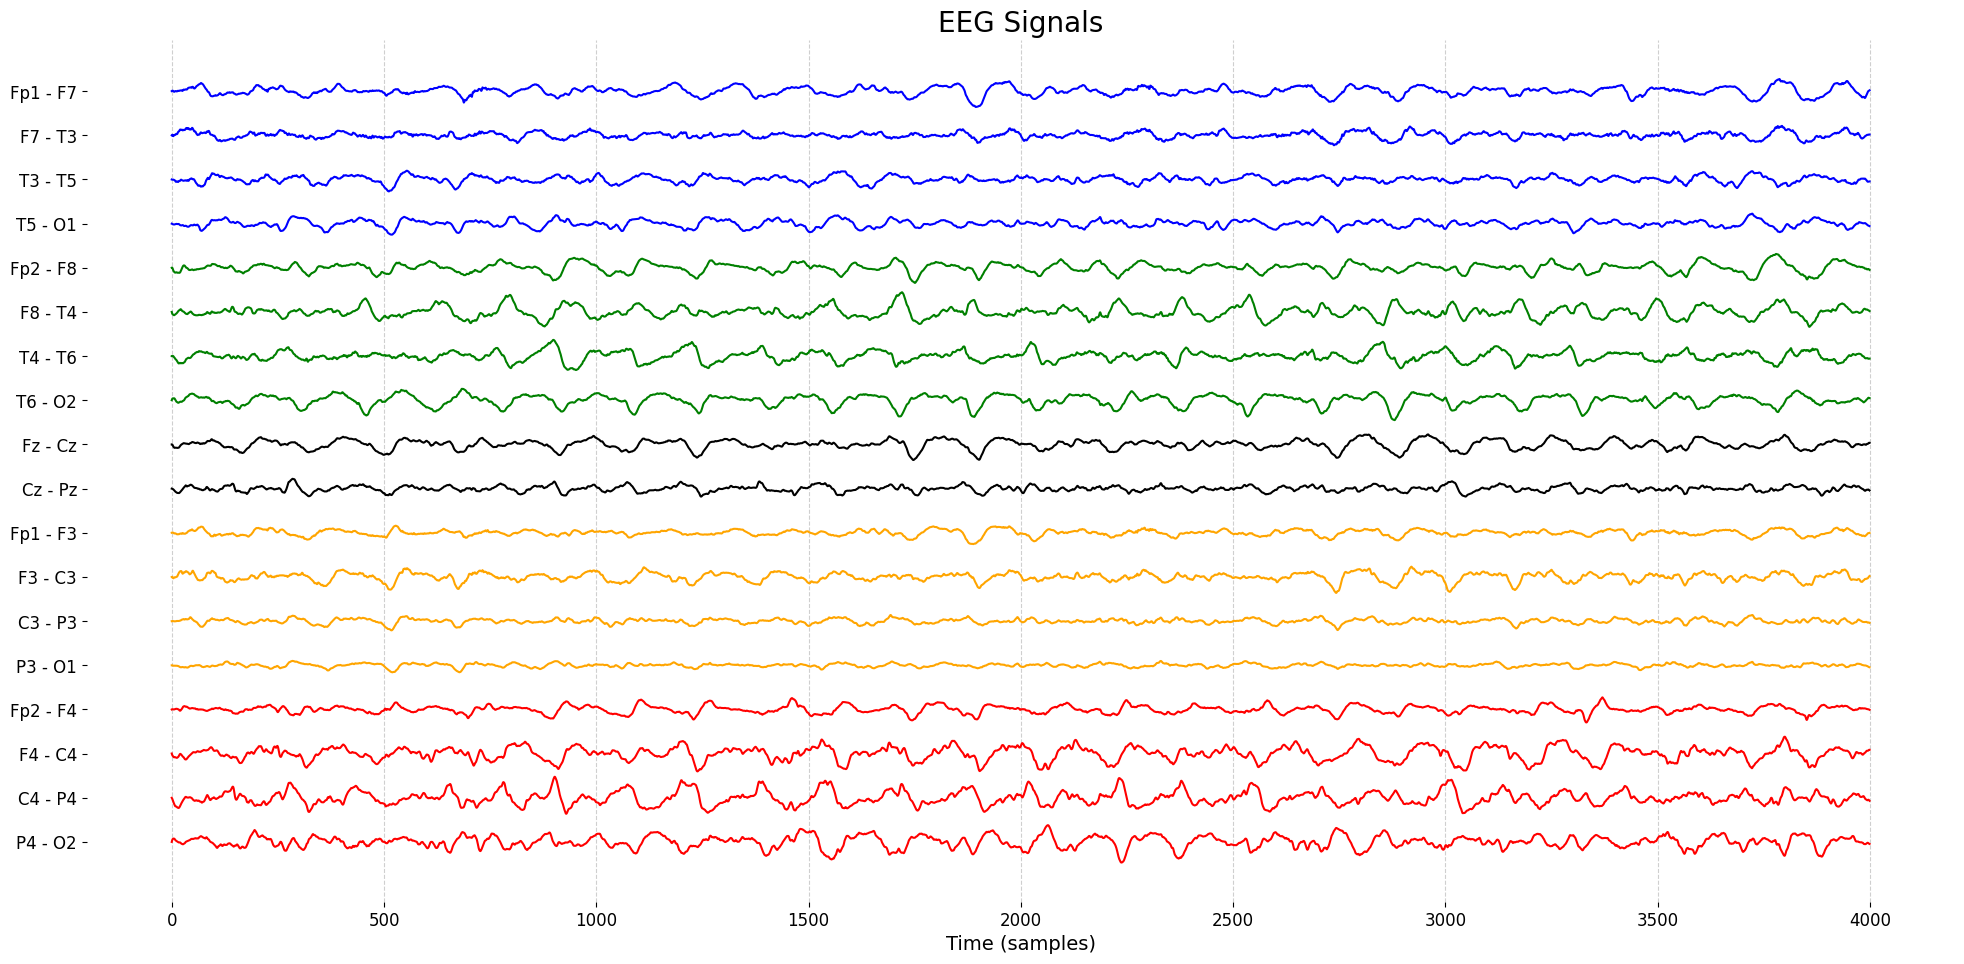

In [14]:
eeg_processed_2 = create_bipolar_montage(baseline_corrected_eeg)
plot_eeg_signals(eeg_processed_2, label = "processed_eeg_2")

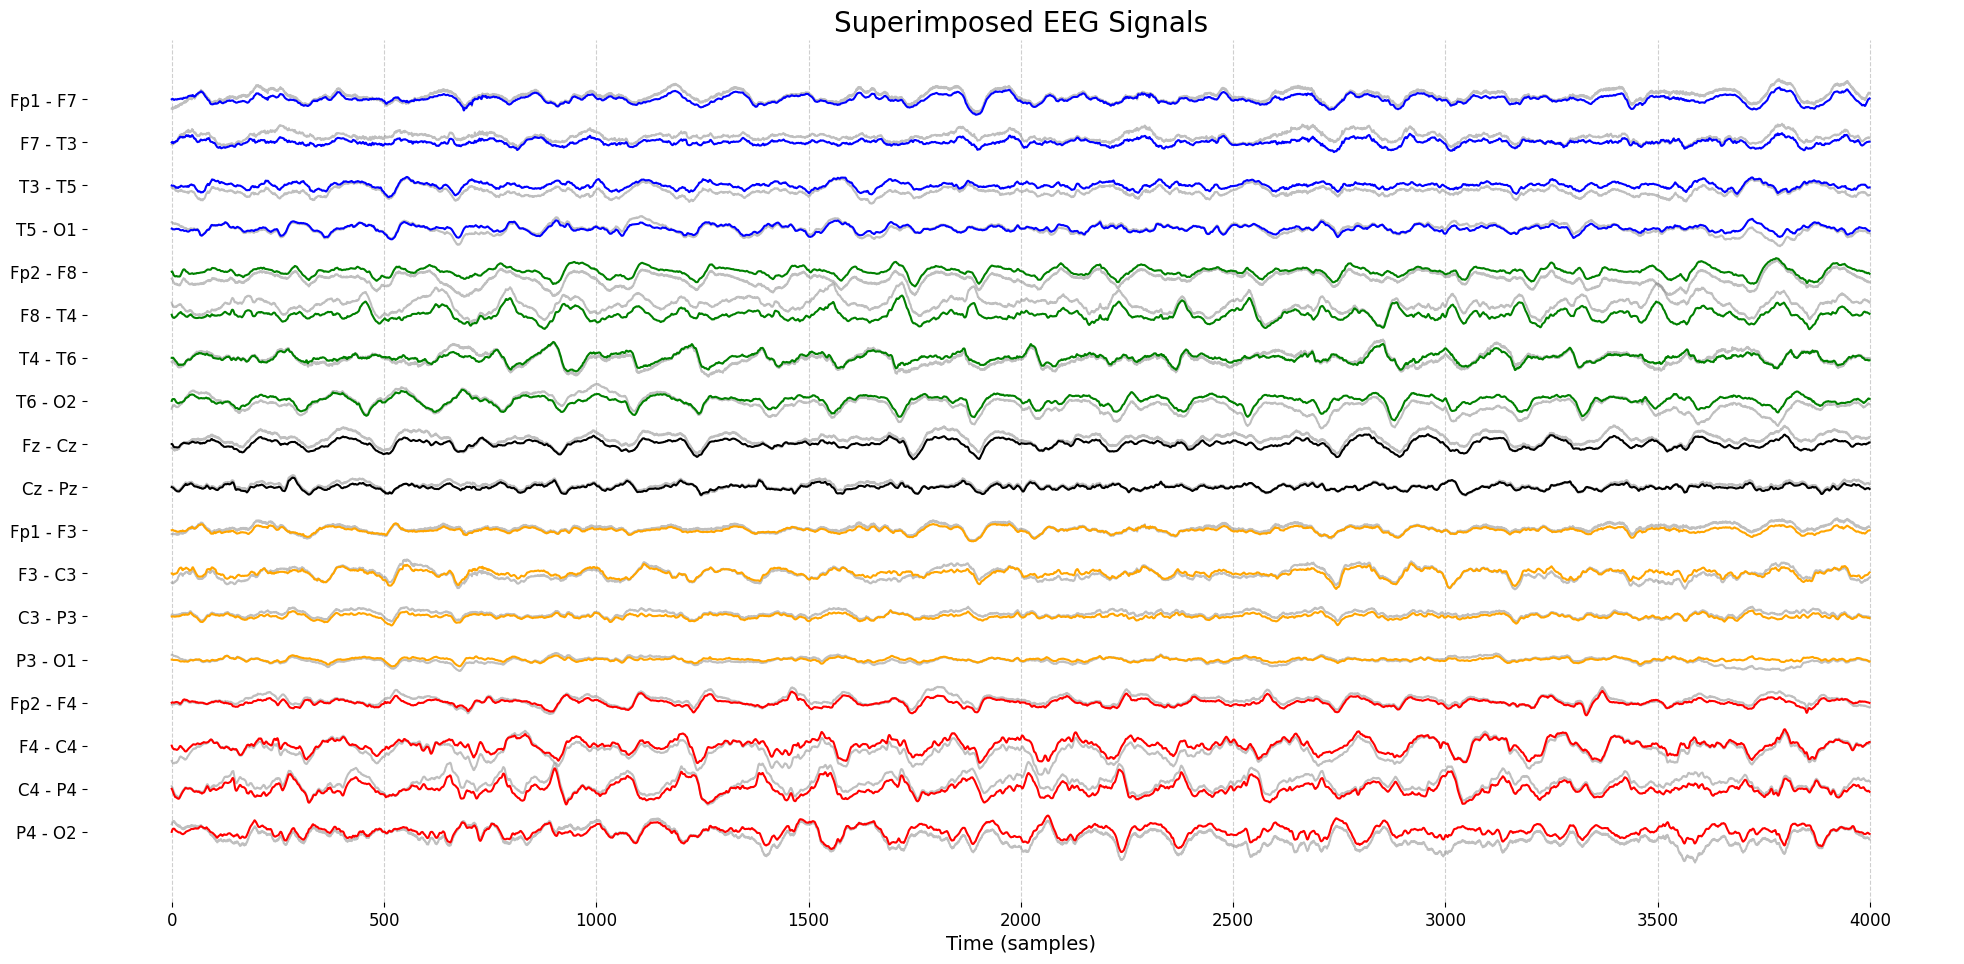

In [15]:
plot_overlapped_eeg_signals(eeg_unprocessed, eeg_processed_2, label = "unprocessed_processed_2", time_limit = 4000)

$\Large\textit{Wavelet Transforms}$ 


$\large\textit{FFT}$ 


In [16]:
from scipy.fftpack import fft

def plot_fft(eeg_data, sampling_rate, channel):
    signal = np.asarray(eeg_data[channel])  
    N = len(signal)
    freq = np.fft.fftfreq(N, d=1/sampling_rate)
    fft_values = fft(signal)
    amplitude = np.abs(fft_values[:N // 2])
    freq = freq[:N // 2]
    
    plt.figure(figsize=(10, 5))
    plt.plot(freq, amplitude)
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Amplitude')
    plt.title(f'FFT - {channel}')
    plt.grid()
    plt.show()

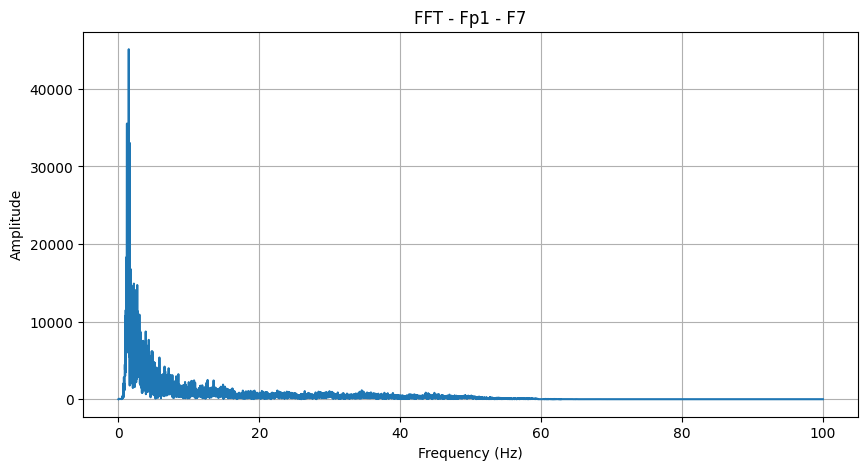

In [17]:
sampling_rate = 200

plot_fft(eeg_processed, sampling_rate, 'Fp1 - F7')

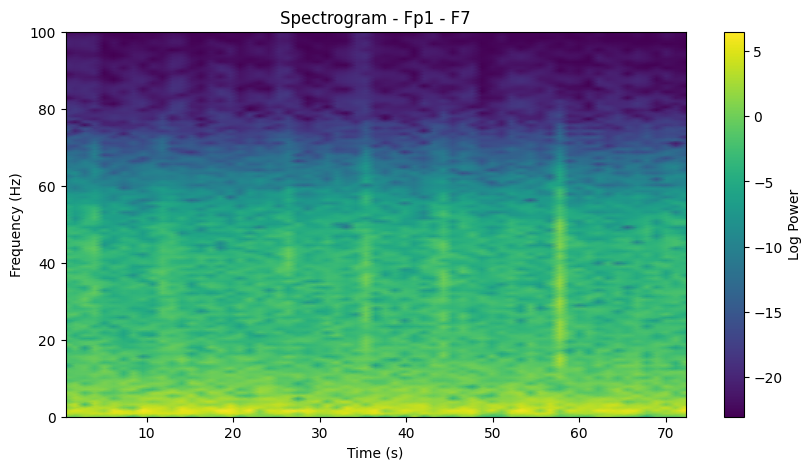

In [18]:
from scipy.signal import spectrogram

def plot_spectrogram(eeg_data, sampling_rate, channel):
    signal = np.asarray(eeg_data[channel]) 
    f, t, Sxx = spectrogram(signal, fs=sampling_rate, nperseg=256)
    
    plt.figure(figsize=(10, 5))
    plt.pcolormesh(t, f, np.log(Sxx + 1e-10), shading='gouraud')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.title(f'Spectrogram - {channel}')
    plt.colorbar(label='Log Power')
    plt.show()

plot_spectrogram(eeg_processed, sampling_rate, 'Fp1 - F7')

$\large\textit{DWT}$ 

In [19]:
import pywt

def wavelet_decomposition(eeg_signal, wavelet='db4', level=4):
    """
    Apply Discrete Wavelet Transform (DWT) to decompose EEG signal.
    """
    coeffs = pywt.wavedec(eeg_signal, wavelet, level=level)
    return coeffs

In [20]:
coeffs = wavelet_decomposition(eeg_processed['Fp1 - F7'], level = 4)
# coeffs = wavelet_decomposition(processed_data.get_data(picks=['F3'])[0])
# coeffs

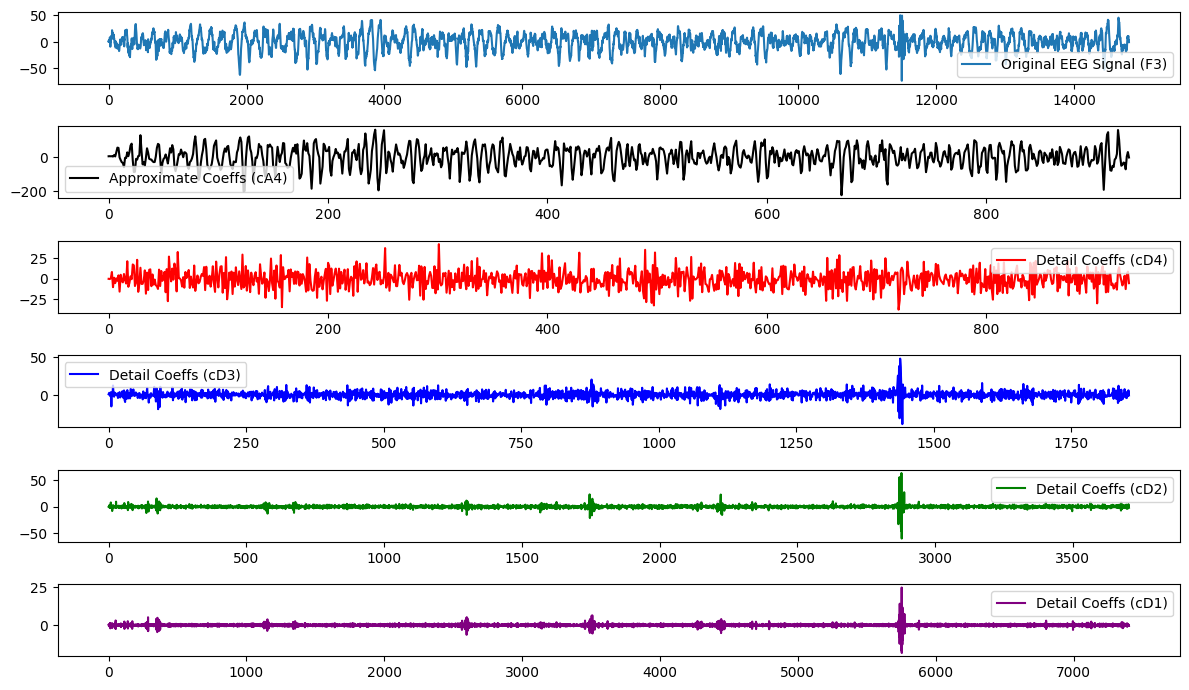

In [21]:
cA4, cD4, cD3, cD2, cD1 = coeffs

# Plot the original signal and wavelet coefficients
plt.figure(figsize=(12, 7))

plt.subplot(6, 1, 1)
plt.plot(eeg_processed['Fp1 - F7'], label="Original EEG Signal (F3)")
plt.legend()

plt.subplot(6, 1, 2)
plt.plot(cA4, label="Approximate Coeffs (cA4)", color="black")
plt.legend()

plt.subplot(6, 1, 3)
plt.plot(cD4, label="Detail Coeffs (cD4)", color="red")
plt.legend()

plt.subplot(6, 1, 4)
plt.plot(cD3, label="Detail Coeffs (cD3)", color="blue")
plt.legend()

plt.subplot(6, 1, 5)
plt.plot(cD2, label="Detail Coeffs (cD2)", color="green")
plt.legend()

plt.subplot(6, 1, 6)
plt.plot(cD1, label="Detail Coeffs (cD1)", color="purple")
plt.legend()

plt.tight_layout()
plt.show()

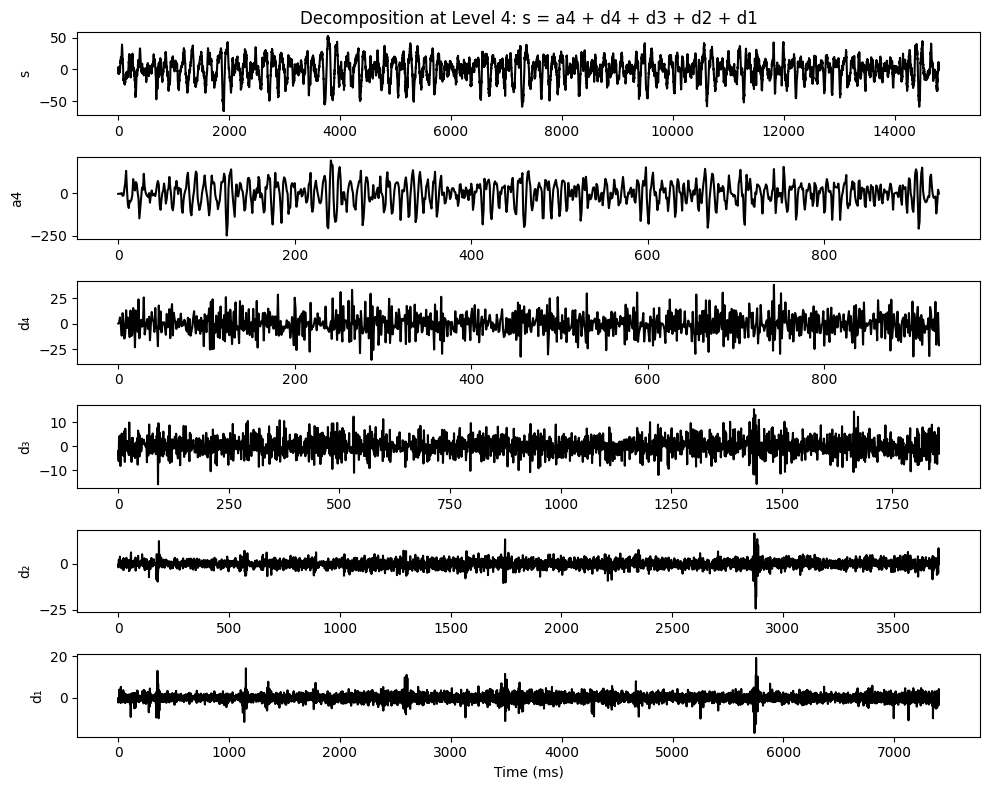

In [23]:
# cA6, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs
eeg_data = eeg_processed['Fp1 - F7']
# Time vector (assuming sampling rate is known)
time = np.linspace(0, 14800, len(eeg_data))  # Adjust for actual sampling rate

# Plot the original signal and wavelet coefficients
plt.figure(figsize=(10, 8))

plt.subplot(6, 1, 1)
plt.plot(time, eeg_data, 'k')
plt.title("Decomposition at Level 4: s = a4 + d4 + d3 + d2 + d1")
plt.ylabel("s")

plt.subplot(6, 1, 2)
plt.plot(time[:len(cA4)], cA4, 'k')
plt.ylabel("a4")

# plt.subplot(8, 1, 3)
# plt.plot(time[:len(cD6)], cD6, 'k')
# plt.ylabel("d₆")

# plt.subplot(8, 1, 4)
# plt.plot(time[:len(cD5)], cD5, 'k')
# plt.ylabel("d₅")

plt.subplot(6, 1, 3)
plt.plot(time[:len(cD4)], cD4, 'k')
plt.ylabel("d₄")

plt.subplot(6, 1, 4)
plt.plot(time[:len(cD3)], cD3, 'k')
plt.ylabel("d₃")

plt.subplot(6, 1, 5)
plt.plot(time[:len(cD2)], cD2, 'k')
plt.ylabel("d₂")

plt.subplot(6, 1, 6)
plt.plot(time[:len(cD1)], cD1, 'k')
plt.ylabel("d₁")
plt.xlabel("Time (ms)")

plt.tight_layout()
plt.show()

In [20]:
# cA6, cD6, cD5, cD4, cD3, cD2, cD1 = coeffs

# plt.figure(figsize=(10, 8))

# plt.subplot(8, 1, 1)
# plt.plot(eeg_processed['Fp1 - F7'])
# plt.title("Original EEG Signal")

# plt.subplot(8, 1, 2)
# plt.plot(cA6, label="Approximation Coeffs (cA6)", color="black")
# plt.legend()

# plt.subplot(8, 1, 3)
# plt.plot(cD6, label="Detail Coeffs (cD6)", color="red")
# plt.legend()

# plt.subplot(8, 1, 4)
# plt.plot(cD5, label="Detail Coeffs (cD5)", color="red")
# plt.legend()

# plt.subplot(8, 1, 5)
# plt.plot(cD4, label="Detail Coeffs (cD4)", color="red")
# plt.legend()

# plt.subplot(8, 1, 6)
# plt.plot(cD3, label="Detail Coeffs (cD3)", color="blue")
# plt.legend()

# plt.subplot(8, 1, 7)
# plt.plot(cD2, label="Detail Coeffs (cD2)", color="green")
# plt.legend()

# plt.subplot(8, 1, 8)
# plt.plot(cD1, label="Detail Coeffs (cD1)", color="purple")
# plt.legend()

# plt.tight_layout()
# plt.show()

In [22]:
energy_A4 = np.sum(np.square(cA4))  # Energy of approximation coefficients
energy_D4 = np.sum(np.square(cD4))  # Energy of detail coefficients at level 4
energy_D3 = np.sum(np.square(cD3))  # Energy of detail coefficients at level 3
energy_D2 = np.sum(np.square(cD2))  # Energy of detail coefficients at level 2
energy_D1 = np.sum(np.square(cD1))  # Energy of detail coefficients at level 1

wavelet_energies = {
    "Approximation (A4)": energy_A4,
    "Detail (D4)": energy_D4,
    "Detail (D3)": energy_D3,
    "Detail (D2)": energy_D2,
    "Detail (D1)": energy_D1
}

# Print wavelet energies
for key, energy in wavelet_energies.items():
    print(f"{key}: {energy:.4f}")

total_energy = energy_A4 + energy_D4 + energy_D3 + energy_D2 + energy_D1

# Compute normalized wavelet energy
normalized_wavelet_energies = {
    "Approximation (A4)": energy_A4 / total_energy,
    "Detail (D4)": energy_D4 / total_energy,
    "Detail (D3)": energy_D3 / total_energy,
    "Detail (D2)": energy_D2 / total_energy,
    "Detail (D1)": energy_D1 / total_energy
}

# Print normalized energies
print("Normalized Wavelet Energy:")
for key, energy in normalized_wavelet_energies.items():
    print(f"{key}: {energy:.4f}")


Approximation (A4): 3272225.0594
Detail (D4): 123431.9117
Detail (D3): 49949.4954
Detail (D2): 39343.7896
Detail (D1): 6008.2566
Normalized Wavelet Energy:
Approximation (A4): 0.9373
Detail (D4): 0.0354
Detail (D3): 0.0143
Detail (D2): 0.0113
Detail (D1): 0.0017


In [22]:
def compute_dwt_frequencies(fs, level):
    """
    Compute the frequency ranges of DWT coefficients for a given sampling frequency and decomposition level.
    
    Args:
    - fs (float): Sampling frequency of the signal (Hz)
    - level (int): Maximum decomposition level

    Returns:
    - freq_bands (dict): Dictionary mapping levels to frequency bands
    """
    freq_bands = {}
    for j in range(1, level + 1):
        f_high = fs / (2 ** (j - 1))  # Upper bound of the band
        f_low = fs / (2 ** j)  # Lower bound of the band
        freq_bands[f"Detail Coeffs (D{j})"] = (f_low, f_high)

    # Approximation coefficients (Lowest frequency band)
    freq_bands[f"Approximation Coeffs (A{level})"] = (0, fs / (2 ** level))

    return freq_bands

# Example Usage
fs = 200  # Sampling frequency of EEG (Hz)
level = 6  # Decomposition level
dwt_freqs = compute_dwt_frequencies(fs, level)

# Print the frequency bands
for coeff, band in dwt_freqs.items():
    print(f"{coeff}: {band[0]:.2f} Hz - {band[1]:.2f} Hz")


Detail Coeffs (D1): 100.00 Hz - 200.00 Hz
Detail Coeffs (D2): 50.00 Hz - 100.00 Hz
Detail Coeffs (D3): 25.00 Hz - 50.00 Hz
Detail Coeffs (D4): 12.50 Hz - 25.00 Hz
Detail Coeffs (D5): 6.25 Hz - 12.50 Hz
Detail Coeffs (D6): 3.12 Hz - 6.25 Hz
Approximation Coeffs (A6): 0.00 Hz - 3.12 Hz


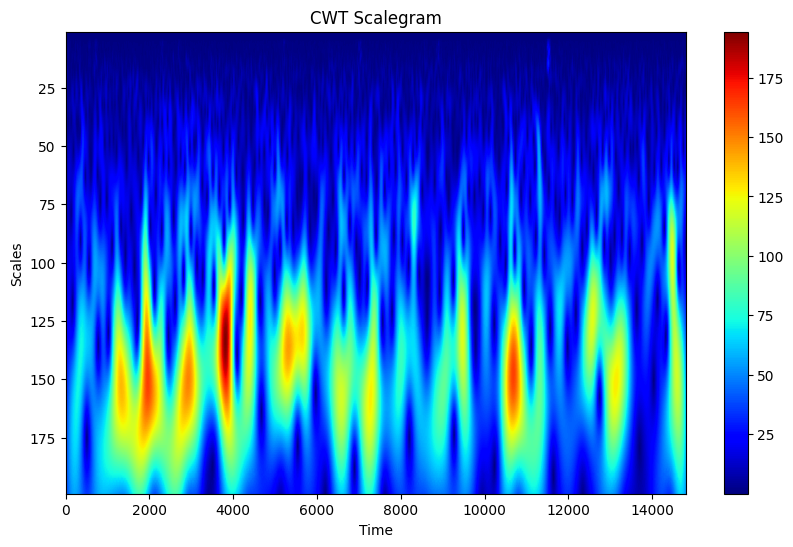

In [23]:
def plot_cwt_scalegram(eeg_signal, wavelet='cmor1.5-1.0', scales=np.arange(1, 200)):
    """
    Perform Continuous Wavelet Transform (CWT) and plot a scalegram.
    """
    coefficients, frequencies = pywt.cwt(eeg_signal, scales, wavelet)
    plt.figure(figsize=(10, 6))
    plt.imshow(np.abs(coefficients), aspect='auto', extent=[0, len(eeg_signal), scales[-1], scales[0]], cmap='jet')
    plt.colorbar()
    plt.xlabel('Time')
    plt.ylabel('Scales')
    plt.title('CWT Scalegram')
    plt.show()

plot_cwt_scalegram(eeg_processed['Fp1 - F7'])

<ipython-input-26-b8a412c1cb6a>:40: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


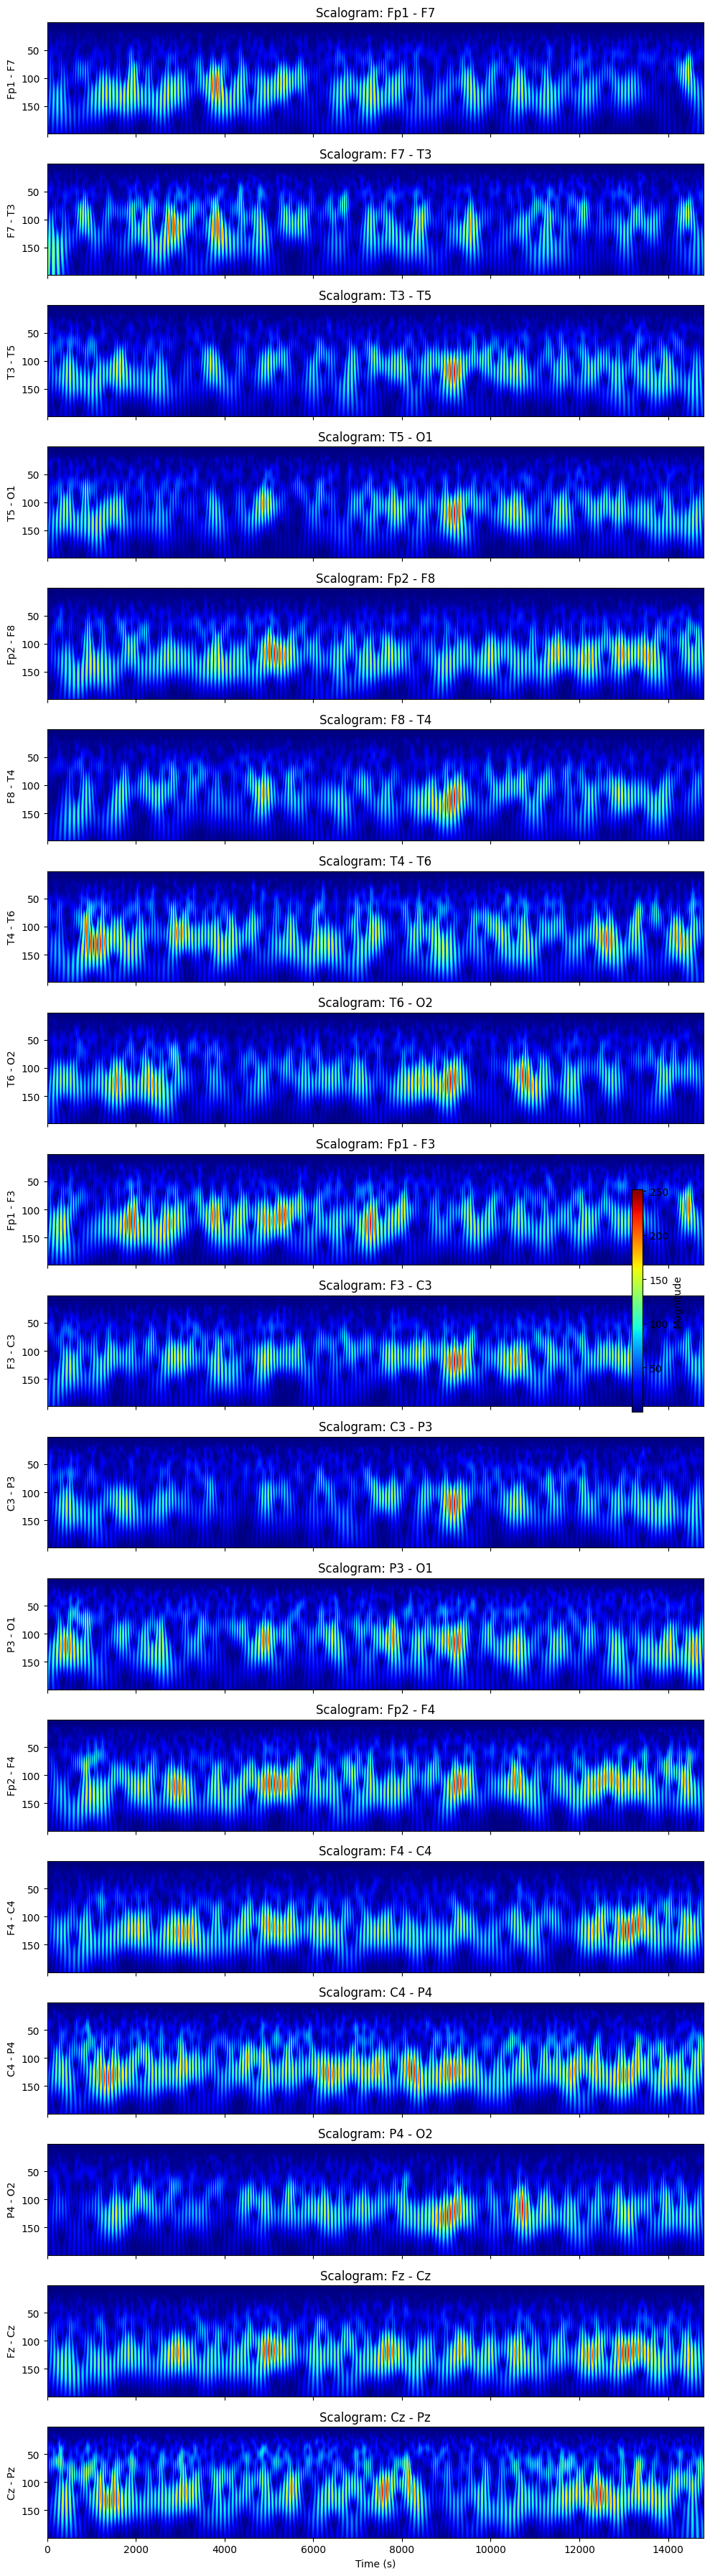

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import pywt
import pandas as pd

def plot_eeg_scalograms(eeg_data, fs=200, wavelet='morl', scales=np.arange(1, 200)):
    """
    Plot scalograms for all EEG channels in a dataset.
    
    Parameters:
    - eeg_data: Pandas DataFrame where each column is an EEG channel.
    - fs: Sampling frequency (default = 200 Hz).
    - wavelet: Wavelet type for CWT (default = 'morl').
    - scales: Range of scales (default = 1 to 128).
    """
    
    num_channels = len(eeg_data.columns)  # Number of EEG channels
    time = np.arange(eeg_data.shape[0])   # Time axis in seconds

    fig, axes = plt.subplots(nrows=num_channels, figsize=(10, 2 * num_channels), sharex=True)

    if num_channels == 1:
        axes = [axes]  # Ensure axes is iterable for a single channel
    
    for i, channel in enumerate(eeg_data.columns):
        signal = eeg_data[channel].values  # Extract EEG signal
        coefficients, frequencies = pywt.cwt(signal, scales, wavelet, 1/fs)  # Compute CWT
        
        # Plot the scalogram
        im = axes[i].imshow(
            np.abs(coefficients), aspect='auto', extent=[0, time[-1], scales[-1], scales[0]], cmap='jet'
        )
        axes[i].set_ylabel(f"{channel}")  # Label each channel
        axes[i].set_title(f"Scalogram: {channel}")

    # Add colorbar
    fig.colorbar(im, ax=axes, orientation='vertical', fraction=0.02, pad=0.02, label="Magnitude")

    axes[-1].set_xlabel("Time (s)")  # Label x-axis only on the last subplot
    plt.tight_layout()
    plt.savefig("Scalogram.png")
    plt.show()

# Example Usage:
# Assuming `eeg_processed` is a DataFrame where each column represents an EEG channel
plot_eeg_scalograms(eeg_processed)


In [ ]:
raw_eeg_data = pd.read_parquet("/kaggle/input/hms-harmful-brain-activity-classification/train_eegs/722738444.parquet")

sfreq = 200

raw_eeg_electrode_data = raw_eeg_data.iloc[:,:-1].to_numpy().T  
raw_eeg_channel_names = list(raw_eeg_data.iloc[:,:-1].columns)
channel_types = ["eeg"] * len(raw_eeg_channel_names)
ekg_data = raw_eeg_data.iloc[:, -1] 

info = mne.create_info(ch_names=raw_eeg_channel_names, sfreq=sfreq, ch_types=channel_types)
raw = mne.io.RawArray(raw_eeg_electrode_data, info)
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage)
raw.set_eeg_reference(ref_channels='average', ch_type = 'eeg')

